In [1]:
import re, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import time 
from tqdm import tqdm
import torch
from nltk.tokenize import sent_tokenize
from data_loaders import create_loaders
from preprocess_data import load_data
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from datasets import load_dataset
from base_model import MHASummarizer
from data_loaders import create_loaders, clean_tokenization_sent, check_dataframe
  
os.environ["TOKENIZERS_PARALLELISM"] = "False"
os.environ["CUDA_VISIBLE_DEVICES"]='7'

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [4]:
#a=pd.read_csv("/scratch/datasets/AttnGraphs_GovReports/Heuristic/order/raw/predict_train_documents.csv")
#a.head()

### Graphs - Summarization Task - Gov Reports

In [2]:
in_path = "/scratch/datasets/GovReport-Sum/"
data_train = None
labels_train = None
data_test = None
labels_test = None

df_train, df_val, df_test = load_data(in_path, data_train, labels_train, data_test, labels_test, with_val=True)

print("\nChecking train")
ids2remove_train= check_dataframe(df_train)
for id_remove in ids2remove_train:
    df_train = df_train.drop(id_remove)    
df_train.reset_index(drop=True, inplace=True)
print ("Train shape:", df_train.shape)

print("\nChecking val")
ids2remove_val = check_dataframe(df_val)
for id_remove in ids2remove_val:
    df_val = df_val.drop(id_remove)    
df_val.reset_index(drop=True, inplace=True)
print ("Val shape:", df_val.shape)

print("\nChecking test")  
ids2remove_test = check_dataframe(df_test)
for id_remove in ids2remove_test:
    df_test = df_test.drop(id_remove)    
df_test.reset_index(drop=True, inplace=True)
print ("Test shape:", df_test.shape)

Loading from Processed folder

Checking train
Train shape: (17482, 4)

Checking val
Val shape: (970, 4)

Checking test
Test shape: (972, 4)


In [19]:
def match_sentences(source_textst, label_list):
    sentences2return = []
    source_list = clean_tokenization_sent(source_textst, 'text')
    print (source_list[:10])
    label_list = clean_tokenization_sent(label_list, 'label')
    label_list = list(np.where(np.asarray(label_list, dtype='int') == 1)[0])
    print (label_list)
    while len(label_list) > 0:
        ide = label_list[0]
        sentences2return.append(source_list[ide])
        label_list.remove(ide)
    
    return sentences2return


In [3]:
df_train.head()

,Article_ID,Cleaned_Article,Summary,Calculated_Labels
0,0,The structure of the armed forces is based on ...,As the Department of Defense (DOD) has expande...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Most income derived from private sector busine...,"Business income taxes, both corporate and nonc...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,There are some similarities in how Medicare pa...,Medicare pays for surgical procedures performe...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,IRS’s mission is to provide America’s taxpayer...,"In collecting taxes, processing returns, and p...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"In 1991, we reported that, historically, INS l...",The Immigration and Naturalization's (INS) org...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [22]:
reference_summary= df_train['Summary'][0]
reference_summary

"As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed federal civilians and interviewed department officials to determine the extent to which DOD has established and the military services and defense agencies (hereafter referred to as DOD components) have implemented (1) force health protection and surveillance policies and (2) medical treatment policies and procedures for its deployed federal civilians. GAO also examined the differences in special pays and benefits provided to DOD's deployed federal civilians and military personnel. DOD has established force health protection and surveill

In [23]:
calculated_summary= match_sentences(df_train['Cleaned_Article'][0], df_train['Calculated_Labels'][0])
calculated_summary

['The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the structure—active duty military personnel, reservists, defense contractors, host nation military and civilian personnel, and DOD federal civilian employees—contribute to national defense.', 'In recent years, federal civilian personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the countries of Bosnia-Herzegovina, Croatia, and Hungary; Joint Guardian, in Kosovo; and Desert Storm, in Southwest Asia.', 'Further, since the beginning of the Global War on Terrorism, the role of DOD’s federal civilian personnel has expanded to include participation in combat support functions in Operations Enduring Freedom and Iraqi Freedom.', 'DOD relies on the federal civilian personnel it deploys to support a range of essential missions, including intelligence collection, criminal investigations, and weapon systems acquisition and maint

['DOD has established force health protection and surveillance policies aimed at assessing and reducing or preventing health risks for its deployed federal civilian personnel; however, the department lacks procedures to ensure the components’ full implementation of its policies.',
 'Our review of deployment records and other documentation at the selected component locations found that these components lacked documentation to show that some federal civilian personnel who deployed to Afghanistan and Iraq had received the required pre-deployment health assessments.',
 'Beyond the aforementioned weaknesses found in the selected components’ implementation of force health protection and surveillance requirements for deploying federal civilians, as a larger issue, DOD lacks comprehensive, centralized data that would enable it to readily identify its deployed civilians, track their movements in theater, or monitor their health status, further hindering efforts to assess the overall effectivene

In [25]:
from rouge_score import rouge_scorer
R_scorer= rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL']) 

labelled_text_i =  " ".join(calculated_summary)
print (labelled_text_i)
rouge_results = R_scorer.score(reference_summary, labelled_text_i)
rouge_results

DOD has established force health protection and surveillance policies aimed at assessing and reducing or preventing health risks for its deployed federal civilian personnel; however, the department lacks procedures to ensure the components’ full implementation of its policies. Our review of deployment records and other documentation at the selected component locations found that these components lacked documentation to show that some federal civilian personnel who deployed to Afghanistan and Iraq had received the required pre-deployment health assessments. Beyond the aforementioned weaknesses found in the selected components’ implementation of force health protection and surveillance requirements for deploying federal civilians, as a larger issue, DOD lacks comprehensive, centralized data that would enable it to readily identify its deployed civilians, track their movements in theater, or monitor their health status, further hindering efforts to assess the overall effectiveness of its 

{'rouge1': Score(precision=0.7729549248747913, recall=0.774247491638796, fmeasure=0.7736006683375105),
 'rouge2': Score(precision=0.5133779264214047, recall=0.5142378559463987, fmeasure=0.5138075313807531),
 'rougeL': Score(precision=0.4974958263772955, recall=0.4983277591973244, fmeasure=0.49791144527986636)}

In [122]:
from graph_data_loaders import AttentionGraphs_Sum, HeuristicGraphs

in_path = "/scratch/datasets/GovReport-Sum/"
filename_train = "predict_train_documents.csv"
filename_val = "predict_val_documents.csv"

path_root = "/scratch/datasets/AttnGraphs_GovReports/Heuristic/order"
heuristic = "order"
dataset_val_order = HeuristicGraphs(root=path_root, filename=filename_val, heuristic=heuristic, path_invert_vocab_sent=in_path, mode="val", task="summarization") 

path_root = "/scratch/datasets/AttnGraphs_GovReports/Heuristic/window"
heuristic = "window"
dataset_val_window = HeuristicGraphs(root=path_root, filename=filename_val, heuristic=heuristic, path_invert_vocab_sent=in_path, mode="val", task="summarization") 

path_root = "/scratch/datasets/AttnGraphs_GovReports/Heuristic/mean_semantic"
heuristic = "mean_semantic"
dataset_val_mean_sem = HeuristicGraphs(root=path_root, filename=filename_val, heuristic=heuristic, path_invert_vocab_sent=in_path, mode="val", task="summarization") 

path_root = "/scratch/datasets/AttnGraphs_GovReports/Heuristic/max_semantic"
heuristic = "max_semantic"
dataset_val_max_sem = HeuristicGraphs(root=path_root, filename=filename_val, heuristic=heuristic, path_invert_vocab_sent=in_path, mode="val", task="summarization") 


In [123]:
root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/2L-Attention/mean"
mean_dataset_val_anneal = AttentionGraphs_Sum(root, filename_val, "mean", None, degree=0.5, mode="val")

root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/2L-Attention/max"
max_dataset_val_anneal = AttentionGraphs_Sum(root, filename_val, "max", None, degree=0.5, mode="val")

root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Sigmoid/2L-Attention/mean"
mean_dataset_val_sig = AttentionGraphs_Sum(root, filename_val, "mean", None, degree=0.5, mode="val")

root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Sigmoid/2L-Attention/max"
max_dataset_val_sig = AttentionGraphs_Sum(root, filename_val, "max", None, degree=0.5, mode="val")

In [5]:
def ide_list2matrix(num_nodes, source, target, attrs=None, binary=True):
    matrix= torch.zeros((num_nodes, num_nodes))
    if binary:
        for i in range(len(source)):
            matrix[source[i]][target[i]]=1
    else:  
        for i in range(len(source)):
            matrix[source[i]][target[i]]=attrs[i]
    
    return matrix

In [113]:
def compare_matrices(data_order, data_window, data_mean_sem, data_max_sem, data_anneal_mean, data_anneal_max, data_sig_mean, data_sig_max, num_print, omit=0, cmap='plasma'): #magma, YlOrBr, viridis

    for idx in range(omit, num_print):
        ##### heuristic based graphs
        source= data_order[idx]['edge_index'][0]
        target= data_order[idx]['edge_index'][1]
        num_nodes = data_order[idx].num_nodes
        matrix_order= ide_list2matrix(num_nodes, source, target, binary=True)
        
        source= data_window[idx]['edge_index'][0]
        target= data_window[idx]['edge_index'][1]
        num_nodes = data_window[idx].num_nodes
        matrix_window= ide_list2matrix(num_nodes, source, target, binary=True)
        
        source= data_mean_sem[idx]['edge_index'][0]
        target= data_mean_sem[idx]['edge_index'][1]
        attrs = data_mean_sem[idx]['edge_attr']
        num_nodes = data_mean_sem[idx].num_nodes
        matrix_mean_sem= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
        
        source= data_max_sem[idx]['edge_index'][0]
        target= data_max_sem[idx]['edge_index'][1]
        attrs = data_max_sem[idx]['edge_attr']
        num_nodes = data_max_sem[idx].num_nodes
        matrix_max_sem= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
    
        ##### Attention based graphs
        source= data_anneal_mean[idx]['edge_index'][0]
        target= data_anneal_mean[idx]['edge_index'][1]
        attrs = data_anneal_mean[idx]['edge_attr']
        num_nodes = data_anneal_mean[idx].num_nodes
        matrix_anneal_mean= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
        matrix_anneal_mean_binary= ide_list2matrix(num_nodes, source, target, binary=True)
        
        source= data_anneal_max[idx]['edge_index'][0]
        target= data_anneal_max[idx]['edge_index'][1]
        attrs = data_anneal_max[idx]['edge_attr']
        num_nodes = data_anneal_max[idx].num_nodes
        matrix_anneal_max= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
        matrix_anneal_max_binary= ide_list2matrix(num_nodes, source, target, binary=True)

        source= data_sig_mean[idx]['edge_index'][0]
        target= data_sig_mean[idx]['edge_index'][1]
        attrs = data_sig_mean[idx]['edge_attr']
        num_nodes = data_sig_mean[idx].num_nodes
        matrix_sig_mean= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
        matrix_sig_mean_binary= ide_list2matrix(num_nodes, source, target, binary=True)
        
        source= data_sig_max[idx]['edge_index'][0]
        target= data_sig_max[idx]['edge_index'][1]
        attrs = data_sig_max[idx]['edge_attr']
        num_nodes = data_sig_max[idx].num_nodes
        matrix_sig_max= ide_list2matrix(num_nodes, source, target, attrs, binary=False)
        matrix_sig_max_binary= ide_list2matrix(num_nodes, source, target, binary=True)
        
    
        fig, axs = plt.subplots(3, 4, figsize=(20,15))
        axs[0, 0].matshow(matrix_order, vmin=0, vmax=1, cmap=cmap)
        axs[0, 0].set_title('Order')
        axs[0, 0].set_xlabel('')
        axs[0, 1].matshow(matrix_window, vmin=0, vmax=1, cmap=cmap)
        axs[0, 1].set_title('Window')
        ### calculate max of max row values 
        axs[0, 2].matshow(matrix_mean_sem, vmin=0, vmax=1, cmap=cmap)
        axs[0, 2].set_title('Mean-Cosine Sim.')
        ### calculate max of max row values 
        axs[0, 3].matshow(matrix_max_sem, vmin=0, vmax=1, cmap=cmap)
        axs[0, 3].set_title('Max-Cosine Sim.')

        ### calculate max of max row values 
        axs[1, 0].matshow(matrix_anneal_mean, vmin=0, vmax=1, cmap=cmap)
        axs[1, 0].set_title('Anneal-Mean')
        ### calculate max of max row values 
        axs[1, 1].matshow(matrix_anneal_mean_binary, vmin=0, vmax=1, cmap=cmap)
        axs[1, 1].set_title('Anneal-Mean (binarized)')
        ### calculate max of max row values 
        axs[1, 2].matshow(matrix_anneal_max, vmin=0, vmax=1, cmap=cmap)
        axs[1, 2].set_title('Anneal-Max')
        ### calculate max of max row values 
        axs[1, 3].matshow(matrix_anneal_max_binary, vmin=0, vmax=1, cmap=cmap)
        axs[1, 3].set_title('Anneal-Max (binarized)')

        ### calculate max of max row values 
        axs[2, 0].matshow(matrix_sig_mean, vmin=0, vmax=1, cmap=cmap)
        axs[2, 0].set_title('Sigmoid-Mean')
        ### calculate max of max row values 
        axs[2, 1].matshow(matrix_sig_mean_binary, vmin=0, vmax=1, cmap=cmap)
        axs[2, 1].set_title('Sigmoid-Mean (binarized)')
        ### calculate max of max row values 
        axs[2, 2].matshow(matrix_sig_max, vmin=0, vmax=1, cmap=cmap)
        axs[2, 2].set_title('Sigmoid-Max')
        ### calculate max of max row values 
        axs[2, 3].matshow(matrix_sig_max_binary, vmin=0, vmax=1, cmap=cmap)
        axs[2, 3].set_title('Sigmoid-Max (binarized)')
        fig.suptitle('Adjency matrix comparison for different graph construction methods', fontsize=16)
        plt.show()

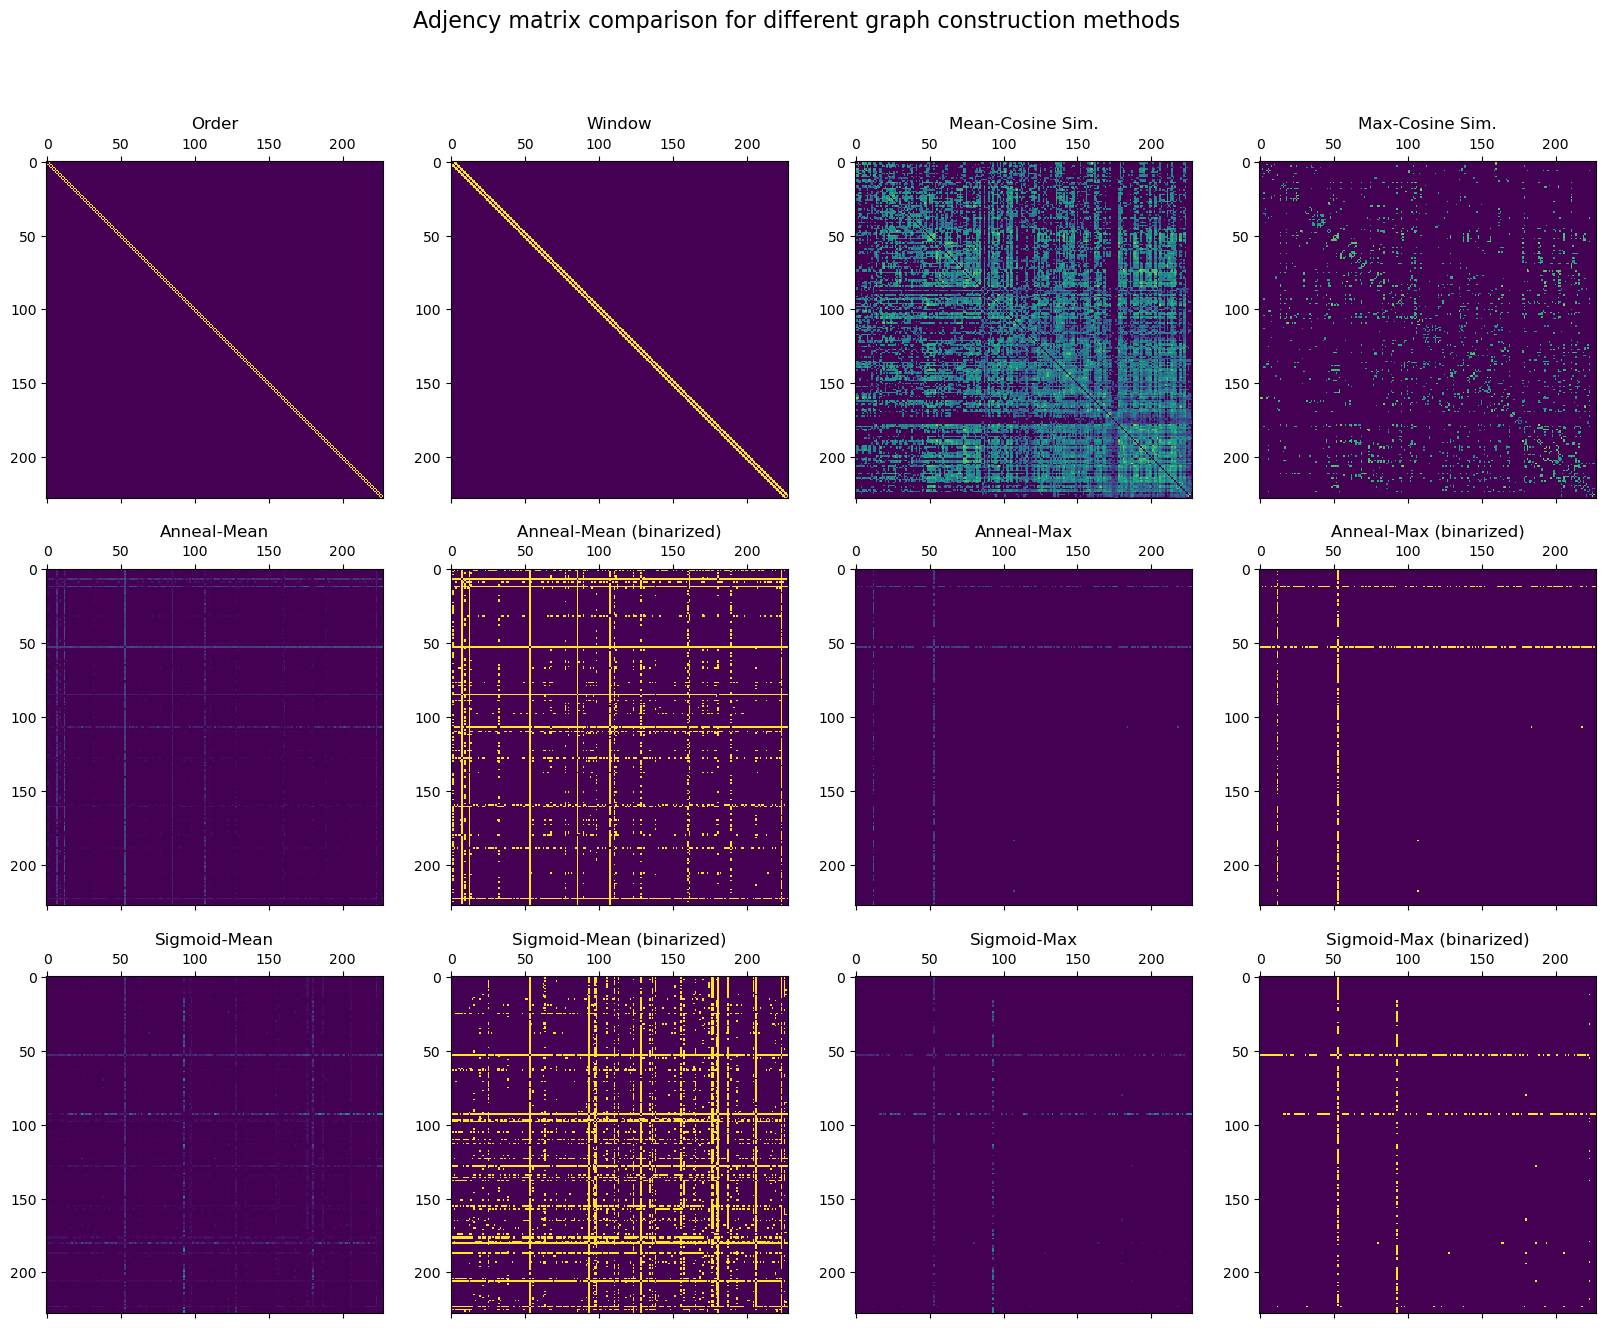

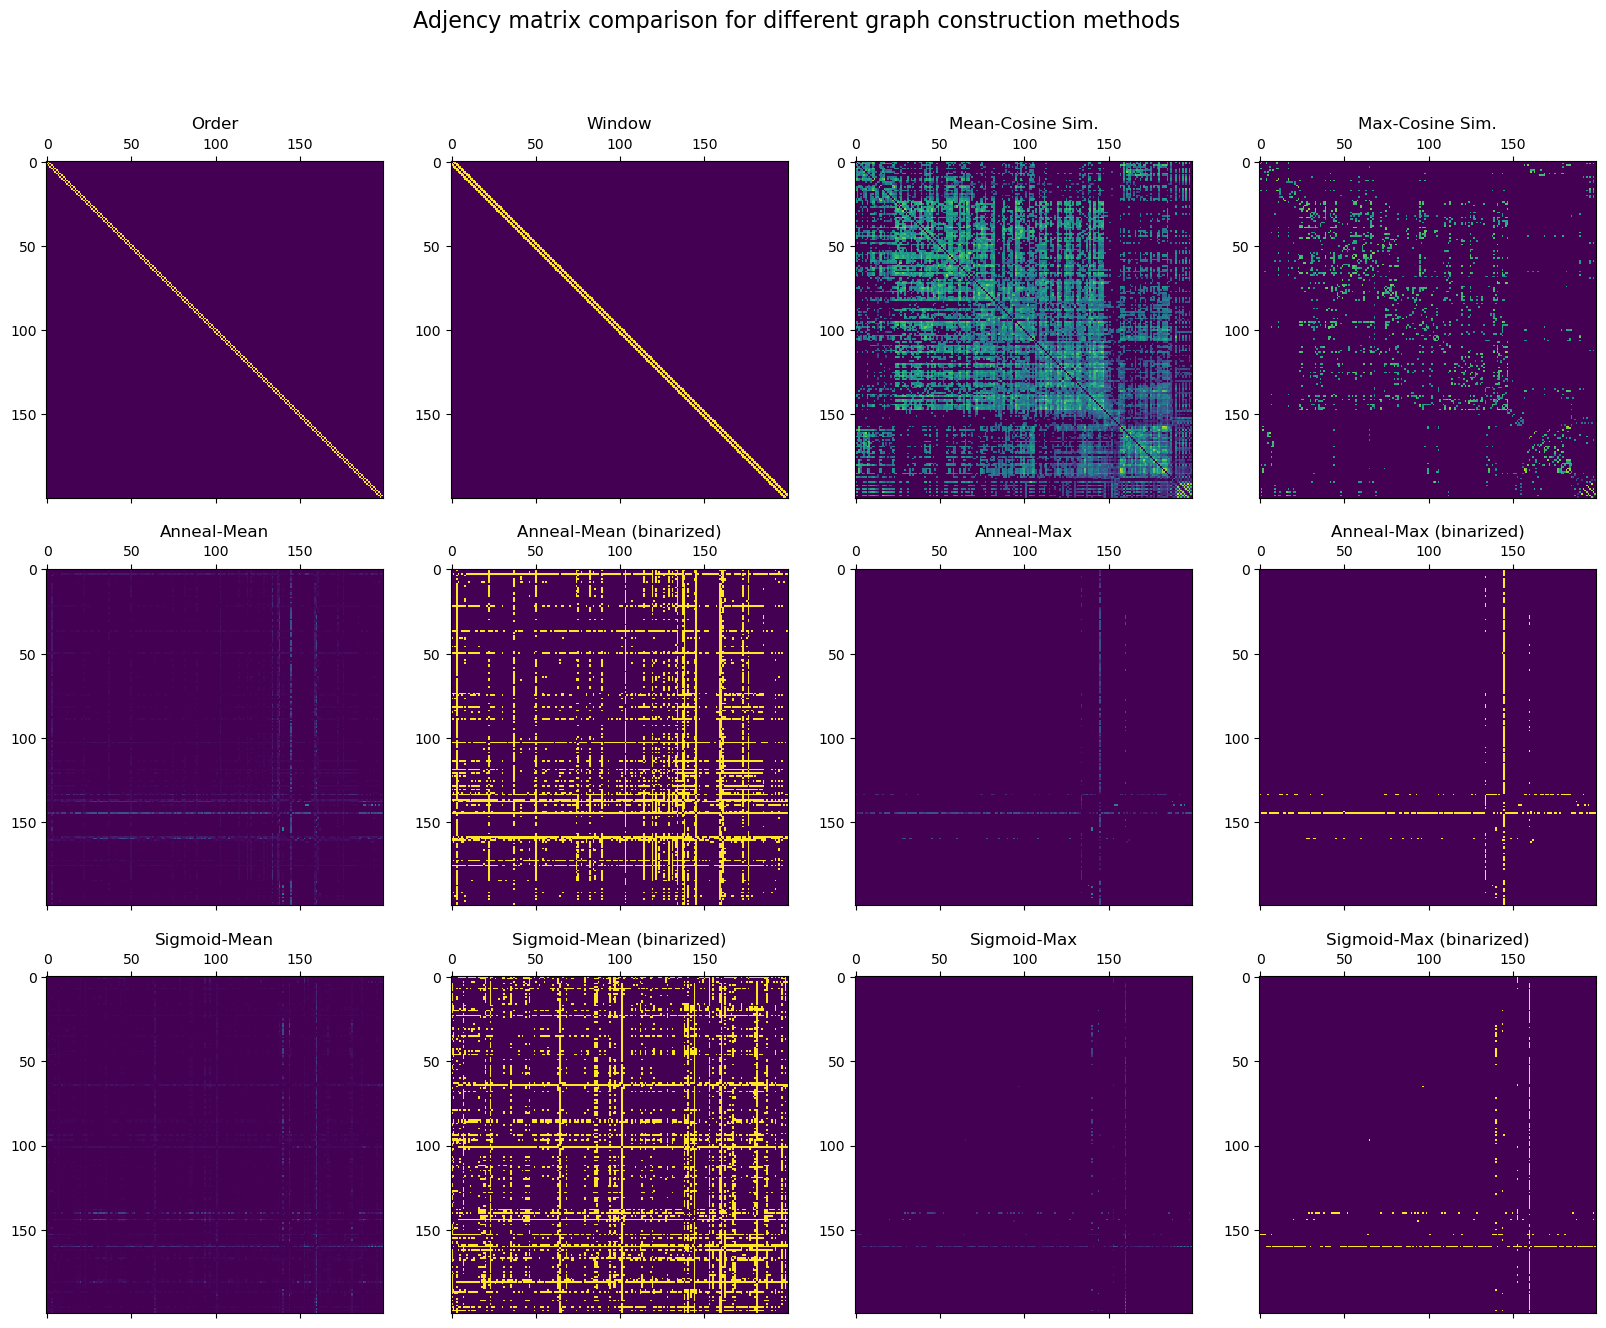

In [128]:
#### Extended_Anneal with 2 MHA layers  
compare_matrices(dataset_val_order, dataset_val_window, dataset_val_mean_sem, dataset_val_max_sem, 
                 mean_dataset_val_anneal, max_dataset_val_anneal, mean_dataset_val_sig, max_dataset_val_sig, 10, 8, cmap='viridis') #magma

In [13]:
max_len = 1000

for i in range(len(dataset_train)):
    data = dataset_train[i] 
    #print(data)
    if data.num_nodes>max_len:
        print('===========================================================================================================')
        # Gather some statistics about the graph.
        print(f'Number of nodes: {data.num_nodes}')
        print(f'Number of edges: {data.num_edges}')
        print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


torch.Size([409, 2])


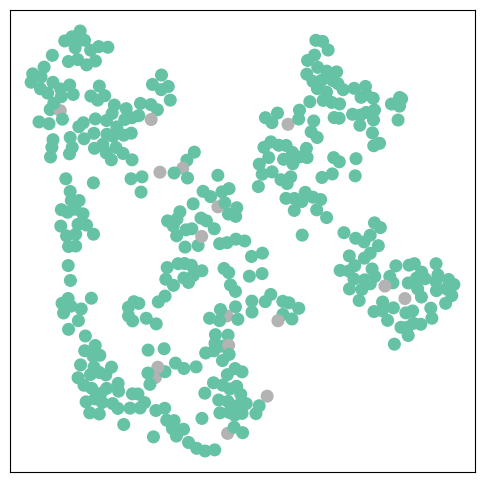

In [17]:
model.eval()

out = model(data.x, data.edge_index, data.edge_attr)
print (out.shape)
visualize(out, color=data.y)

In [5]:
from graph_data_loaders import AttentionGraphs_Sum
from preprocess_data import load_data
from data_loaders import get_class_weights
  
root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean"
in_path = "/scratch/datasets/GovReport-Sum/"
data_train = None
labels_train = None
data_test = None
labels_test = None
        
filename_train = "predict_train_documents.csv"
filename_val= "predict_val_documents.csv" 
filename_test= "predict_test_documents.csv"

dataset_train = AttentionGraphs_Sum(root, filename_train, "mean", None, degree=0.5, mode="train")
dataset_val = AttentionGraphs_Sum(root, filename_val, "mean", None, degree=0.5, mode="val")
dataset_test = AttentionGraphs_Sum(root, filename_test, "mean", None, degree=0.5, mode="test")

df_train, df_val, df_test = load_data(in_path, data_train, labels_train, data_test, labels_test, with_val=True)

print("\nChecking train")
ids2remove_train= check_dataframe(df_train)
for id_remove in ids2remove_train:
    df_train = df_train.drop(id_remove)    
df_train.reset_index(drop=True, inplace=True)
print ("Train shape:", df_train.shape)

print("\nChecking val")
ids2remove_val = check_dataframe(df_val)
for id_remove in ids2remove_val:
    df_val = df_val.drop(id_remove)    
df_val.reset_index(drop=True, inplace=True)
print ("Val shape:", df_val.shape)

print("\nChecking test")  
ids2remove_test = check_dataframe(df_test)
for id_remove in ids2remove_test:
    df_test = df_test.drop(id_remove)    
df_test.reset_index(drop=True, inplace=True)
print ("Test shape:", df_test.shape)

my_class_weights, labels_counter = get_class_weights(df_train, task="summarization")
print ("\nClass weights - from training partition:", my_class_weights)
print ("Class counter:", labels_counter)

Loading from Processed folder

Checking train
Train shape: (17482, 4)

Checking val
Val shape: (970, 4)

Checking test
Test shape: (972, 4)

Class weights - from training partition: tensor([ 0.5430, 12.4261])
Class counter: {1: 260126, 0: 4816789}


In [6]:
del df_train, df_val, df_test

Creating GAT model
Done


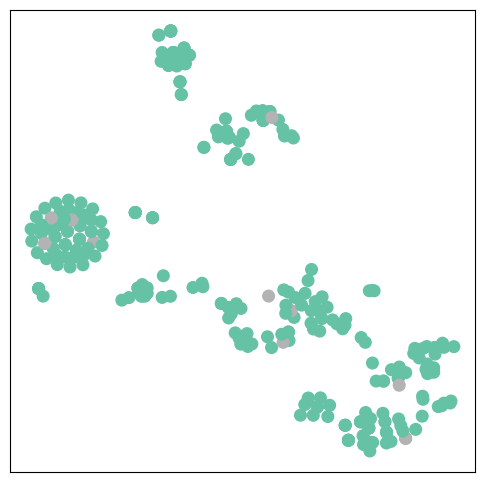

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | convs     | ModuleList       | 165 K  | train
1 | lastConv  | GATConv          | 518    | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.664     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


partititons created


Metric Val_f1-ma improved. New best score: 0.273
Metric Val_f1-ma improved by 0.033 >= min_delta = 0.001. New best score: 0.306
Metric Val_f1-ma improved by 0.034 >= min_delta = 0.001. New best score: 0.339
Monitored metric Val_f1-ma did not improve in the last 7 records. Best score: 0.339. Signaling Trainer to stop.



Training stopped on epoch: 16
Training time: 4870.41 secs
Best model path: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/GAT/mean/GAT_2L_64U_mean_run0-OUT-epoch=09-Val_f1-ma=0.34.ckpt
Acc Test: tensor(0.5832)
F1-macro Test: tensor(0.4341)
F1 for each class: tensor([0.7245, 0.1437])
Training + Testing time: 5064.396422624588


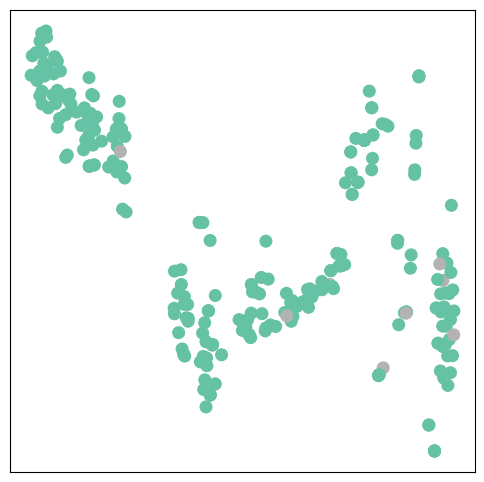

In [8]:
from gnn_model import partitions
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import F1Score

type_model = "GAT"
type_graph = "mean"
graph_construction = type_graph
model_name  = "Extended_Anneal"
path_models = "/scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/"
project_name = model_name+"2"+type_model+"_"+type_graph

acc_tests=[]
f1_tests=[]
f1ma_tests=[]
all_train_times=[]
all_full_times=[]

for i in range(1):  
    nl = 2
    dim = 64
    
    model = GAT_model(dataset_train.num_node_features, dim, 2, nl, 0.001, dropout=0.1, class_weights=my_class_weights)    
    
    #### first train sample before model fitting
    model.eval()
    data= dataset_train[0] 
    out_sample = model(data.x, data.edge_index, data.edge_attr, data.batch)
    visualize(out_sample, color=data.y)
    model.train()
    #### 
               
    early_stop_callback = EarlyStopping(monitor="Val_f1-ma", mode="max", verbose=True, patience=7, min_delta= 0.001  )
    path_for_savings = path_models+type_model+"/"+graph_construction # if config_file["baseline"] else path_models+type_model
    checkpoint_callback = ModelCheckpoint(monitor="Val_f1-ma", mode="max", save_top_k=1, dirpath=path_for_savings, filename=type_model+"_"+str(nl)+"L_"+str(dim)+"U_"+graph_construction+"_run"+str(i)+"-OUT-{epoch:02d}-{Val_f1-ma:.2f}")
    wandb_logger = WandbLogger(name=model_name+'2'+type_model+"_"+str(nl)+"L_"+str(dim)+"U_"+graph_construction+"_run"+str(i), save_dir=path_for_savings, project=project_name)
    trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback, checkpoint_callback], logger=wandb_logger, max_epochs= 50, enable_progress_bar= False)

    train_loader, val_loader, test_loader = partitions(dataset_train, dataset_test, dataset_val=dataset_val, bs=8)
    print ("partititons created")
    
    starti = time.time()
    trainer.fit(model, train_loader, val_loader)

    print ("\nTraining stopped on epoch:", trainer.callbacks[0].stopped_epoch)
    train_time = time.time()-starti
    print(f"Training time: {train_time:.2f} secs")   

    # load best checkpoint
    print ("Best model path:", trainer.checkpoint_callback.best_model_path)
    checkpoint = torch.load(trainer.checkpoint_callback.best_model_path)
    model.load_state_dict(checkpoint['state_dict']) 

    preds, trues = model.predict(test_loader, cpu_store=False)

    acc=(torch.Tensor(trues) ==preds).float().mean() 
    f1_score = F1Score(task='multiclass', num_classes=2, average='none')
    f1_all = f1_score(preds.int(), torch.Tensor(trues).int())
    print ("Acc Test:", acc)
    print ("F1-macro Test:", f1_all.mean())
    print ("F1 for each class:", f1_all)

    endi = time.time()
    total_timei = endi - starti
    print("Training + Testing time: "+ str(total_timei))

    acc_tests.append(acc.cpu().numpy())
    f1_tests.append(f1_all.cpu().numpy())
    f1ma_tests.append(f1_all.mean().cpu().numpy())
    all_train_times.append(train_time)
    all_full_times.append(total_timei)

    #### first train sample after model fitting
    model.eval()
    out_sample = model(data.x, data.edge_index, data.edge_attr, data.batch)
    visualize(out_sample, color=data.y)
    model.train()
    ####

In [ ]:
print ("\n************************************************", file=f)
print ("RESULTS FOR N_LAYERS:", nl, " HIDDEN DIM_FEATURES:", dim, file=f)    
print ("Test Acc: %.3f"% np.mean(np.asarray(acc_tests)), "-- std: %.3f" % np.std(np.asarray(acc_tests)), file=f)
print ("Test F1-macro: %.3f"%np.mean(np.asarray(f1ma_tests)), "-- std: %.3f" % np.std(np.asarray(f1ma_tests)), file=f)
print ("Test F1 per class:", np.mean(np.asarray(f1_tests), axis=0), file=f)
print ("Training time: %.2f"%np.mean(np.asarray(all_train_times)), "-- std: %.2f" % np.std(np.asarray(all_train_times)), file=f)
print ("Total time: %.2f"%np.mean(np.asarray(all_full_times)), "-- std: %.2f" % np.std(np.asarray(all_full_times)), file=f)
print ("************************************************\n\n", file=f)

In [6]:
from data_loaders import create_loaders
from eval_models import retrieve_parameters, eval_results

logger_name = "df_logger.csv" 
model_name = "Extended_Anneal"
path_logger = "/scratch/mbugueno/HomoGraphs_HND/"

df_logger = pd.read_csv(path_logger+logger_name)    
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)

In [7]:
loader_train, loader_val, loader_test, df_train, df_val, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, 32, with_val=True,
                                                                                               tokenizer_from_scratch=False, path_ckpt=path_checkpoint)